# FlashDeconv: Fast Spatial Deconvolution via Structure-Preserving Sketching

This notebook demonstrates how to use FlashDeconv for spatial transcriptomics cell type deconvolution through the unified `omicverse.space.Deconvolution` API.

## Why FlashDeconv?

- **Scalability**: Handles millions of spots (Visium HD, Slide-seq) without GPU requirement
- **Speed**: Uses randomized sketching for O(n) complexity instead of O(n²)
- **Spatial awareness**: Incorporates graph Laplacian regularization for spatially smooth results
- **Integration**: scanpy-style API, seamlessly works with AnnData objects

## Inputs and Outputs

- **Inputs**:
  - Spatial transcriptomics data (10x Visium, Visium HD, Slide-seq, etc.)
  - Single-cell reference with cell type annotations
- **Outputs**:
  - Cell type proportions per spot (stored in `adata.obsm['flashdeconv']`)
  - Dominant cell type per spot
  - Compatible `adata_cell2location` object for downstream analysis

## Workflow Overview

1. Load scRNA-seq reference and spatial data (~1 min)
2. Run FlashDeconv deconvolution (~2-5 min for standard Visium)
3. Visualize results (~5 min)

In [1]:
import omicverse as ov
import scanpy as sc
import matplotlib.pyplot as plt

ov.plot_set(font_path='Arial')

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting GPU devices…
✅ NVIDIA CUDA GPUs detected: 1
    • [CUDA 0] NVIDIA H100 80GB HBM3
      Memory: 79.1 GB | Compute: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.9rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Step 1: Load Data

### 1.1 Load scRNA-seq reference

The reference should contain cell type annotations in `.obs`.

In [ ]:
# Load your scRNA-seq reference
# Example: Human lymph node reference
adata_sc = ov.datasets.sc_ref_Lymph_Node()

# Check cell type annotations
print(adata_sc.obs['Subset'].value_counts())

Subset
B_mem               13476
B_naive              8924
T_CD4+_naive         6012
B_Cycling            4765
T_CD4+_TfH           4690
T_CD8+_cytotoxic     3890
T_CD4+_TfH_GC        3653
B_activated          3575
B_GC_LZ              3298
T_CD4+               3059
T_Treg               2958
B_GC_DZ              2500
T_CD8+_CD161+        2294
T_CD8+_naive         2253
NK                   1372
B_plasma             1094
T_TfR                1065
NKT                   896
Endo                  622
ILC                   617
B_preGC               404
T_TIM3+               357
Monocytes             306
DC_pDC                226
B_IFN                 199
DC_cDC2               173
Macrophages_M1        121
Macrophages_M2        110
DC_cDC1               101
FDC                    76
B_GC_prePB             74
DC_CCR7+               42
VSMC                   40
Mast                   18
Name: count, dtype: int64


### 1.2 Load spatial transcriptomics data

In [3]:
# Load spatial data (example: Visium human lymph node)
adata_sp = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_sp.obs['sample'] = list(adata_sp.uns['spatial'].keys())[0]
adata_sp.var_names_make_unique()

print(f"Spatial data: {adata_sp.n_obs} spots, {adata_sp.n_vars} genes")

reading /scratch/users/steorra/analysis/omic_test/data/V1_Human_Lymph_Node/filtered_feature_bc_matrix.h5
 (0:00:00)
Spatial data: 4035 spots, 36601 genes


## Step 2: Run FlashDeconv Deconvolution

FlashDeconv is integrated into the `omicverse.space.Deconvolution` class. Simply set `method='FlashDeconv'`.

### Key Parameters

- `sketch_dim`: Dimension of sketched space (default: 512). Higher values preserve more information.
- `lambda_spatial`: Spatial regularization strength (default: 5000). Higher values encourage smoother spatial patterns.
- `n_hvg`: Number of highly variable genes to use (default: 2000).
- `n_markers_per_type`: Number of marker genes per cell type (default: 50).

In [4]:
# Initialize the Deconvolution object
decov_obj = ov.space.Deconvolution(
    adata_sc=adata_sc,
    adata_sp=adata_sp
)

In [6]:
# Run FlashDeconv deconvolution
decov_obj.deconvolution(
    method='FlashDeconv',
    celltype_key_sc='Subset',  # Column containing cell type annotations
    flashdeconv_kwargs={
        'sketch_dim': 512,          # Sketch dimension
        'lambda_spatial': 10.0,   # Spatial regularization
        'n_hvg': 3000,              # Number of HVGs
        'n_markers_per_type': 50,   # Markers per cell type
    }
)

Running FlashDeconv with parameters: {'sketch_dim': 512, 'lambda_spatial': 10.0, 'n_hvg': 3000, 'n_markers_per_type': 50}
✓ FlashDeconv deconvolution is done
The deconvolution result is saved in self.adata_cell2location
Cell type proportions are also stored in self.adata_sp.obsm['flashdeconv']


### Access Results

Results are stored in multiple locations for compatibility:
- `decov_obj.adata_cell2location`: AnnData with cell type proportions as X matrix
- `decov_obj.adata_sp.obsm['flashdeconv']`: DataFrame of proportions
- `decov_obj.adata_sp.obs['flashdeconv_dominant']`: Dominant cell type per spot

In [7]:
# View the result object
decov_obj.adata_cell2location

AnnData object with n_obs × n_vars = 4035 × 34
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'flashdeconv_B_Cycling', 'flashdeconv_B_GC_DZ', 'flashdeconv_B_GC_LZ', 'flashdeconv_B_GC_prePB', 'flashdeconv_B_IFN', 'flashdeconv_B_activated', 'flashdeconv_B_mem', 'flashdeconv_B_naive', 'flashdeconv_B_plasma', 'flashdeconv_B_preGC', 'flashdeconv_DC_CCR7+', 'flashdeconv_DC_cDC1', 'flashdeconv_DC_cDC2', 'flashdeconv_DC_pDC', 'flashdeconv_Endo', 'flashdeconv_FDC', 'flashdeconv_ILC', 'flashdeconv_Macrophages_M1', 'flashdeconv_Macrophages_M2', 'flashdeconv_Mast', 'flashdeconv_Monocytes', 'flashdeconv_NK', 'flashdeconv_NKT', 'flashdeconv_T_CD4+', 'flashdeconv_T_CD4+_TfH', 'flashdeconv_T_CD4+_TfH_GC', 'flashdeconv_T_CD4+_naive', 'flashdeconv_T_CD8+_CD161+', 'flashdeconv_T_CD8+_cytotoxic', 'flashdeconv_T_CD8+_naive', 'flashdeconv_T_TIM3+', 'flashdeconv_T_TfR', 'flashdeconv_T_Treg', 'flashdeconv_VSMC', 'flashdeconv_dominant'
    uns: 'spatial', 'flashdeconv_params'
    obsm: 'spatial', 'f

In [8]:
# View cell type proportions
decov_obj.adata_sp.obsm['flashdeconv'].head()

B_Cycling   B_GC_DZ  B_GC_LZ  B_GC_prePB     B_IFN  \
AAACAAGTATCTCCCA-1   0.000000  0.142163      0.0         0.0  0.000000   
AAACAATCTACTAGCA-1   0.000000  0.163051      0.0         0.0  0.000000   
AAACACCAATAACTGC-1   0.016557  0.130161      0.0         0.0  0.000000   
AAACAGAGCGACTCCT-1   0.000000  0.172508      0.0         0.0  0.225865   
AAACAGCTTTCAGAAG-1   0.000000  0.150919      0.0         0.0  0.000000   

                    B_activated  B_mem   B_naive  B_plasma  B_preGC  ...  \
AAACAAGTATCTCCCA-1          0.0    0.0  0.085327  0.390464      0.0  ...   
AAACAATCTACTAGCA-1          0.0    0.0  0.000000  0.116814      0.0  ...   
AAACACCAATAACTGC-1          0.0    0.0  0.046586  0.232831      0.0  ...   
AAACAGAGCGACTCCT-1          0.0    0.0  0.000000  0.078707      0.0  ...   
AAACAGCTTTCAGAAG-1          0.0    0.0  0.403057  0.133602      0.0  ...   

                    T_CD4+_TfH  T_CD4+_TfH_GC  T_CD4+_naive  T_CD8+_CD161+  \
AAACAAGTATCTCCCA-1         0.0       0.000000      0.000000            0.0   
AAACAATCTACTAGCA-1         0.0       0.049438      0.176642            0.0   
AAACACCAATAACTGC-1         0.0       0.000000      0.000000            0.0   
AAACAGAGCGACTCCT-1         0.0       0.000000      0.000000            0.0   
AAACAGCTTTCAGAAG-1         0.0       0.000000      0.000000            0.0   

                    T_CD8+_cytotoxic  T_CD8+_naive   T_TIM3+    T_TfR  T_Treg  \
AAACAAGTATCTCCCA-1               0.0      0.000000  0.000000  0.00000     0.0   
AAACAATCTACTAGCA-1               0.0      0.005135  0.000000  0.15238     0.0   
AAACACCAATAACTGC-1               0.0      0.000000  0.013086  0.00000     0.0   
AAACAGAGCGACTCCT-1               0.0      0.000000  0.126967  0.00000     0.0   
AAACAGCTTTCAGAAG-1               0.0      0.000000  0.000000  0.00000     0.0   

                        VSMC  
AAACAAGTATCTCCCA-1  0.040701  
AAACAATCTACTAGCA-1  0.026961  
AAACACCAATAACTGC-1  0.054721  
AAACAGAGCGACTCCT-1  0.000000  
AAACAGCTTTCAGAAG-1  0.000000  

[5 rows x 34 columns]

## Step 3: Visualization

### 3.1 Spatial heatmap of cell type proportions

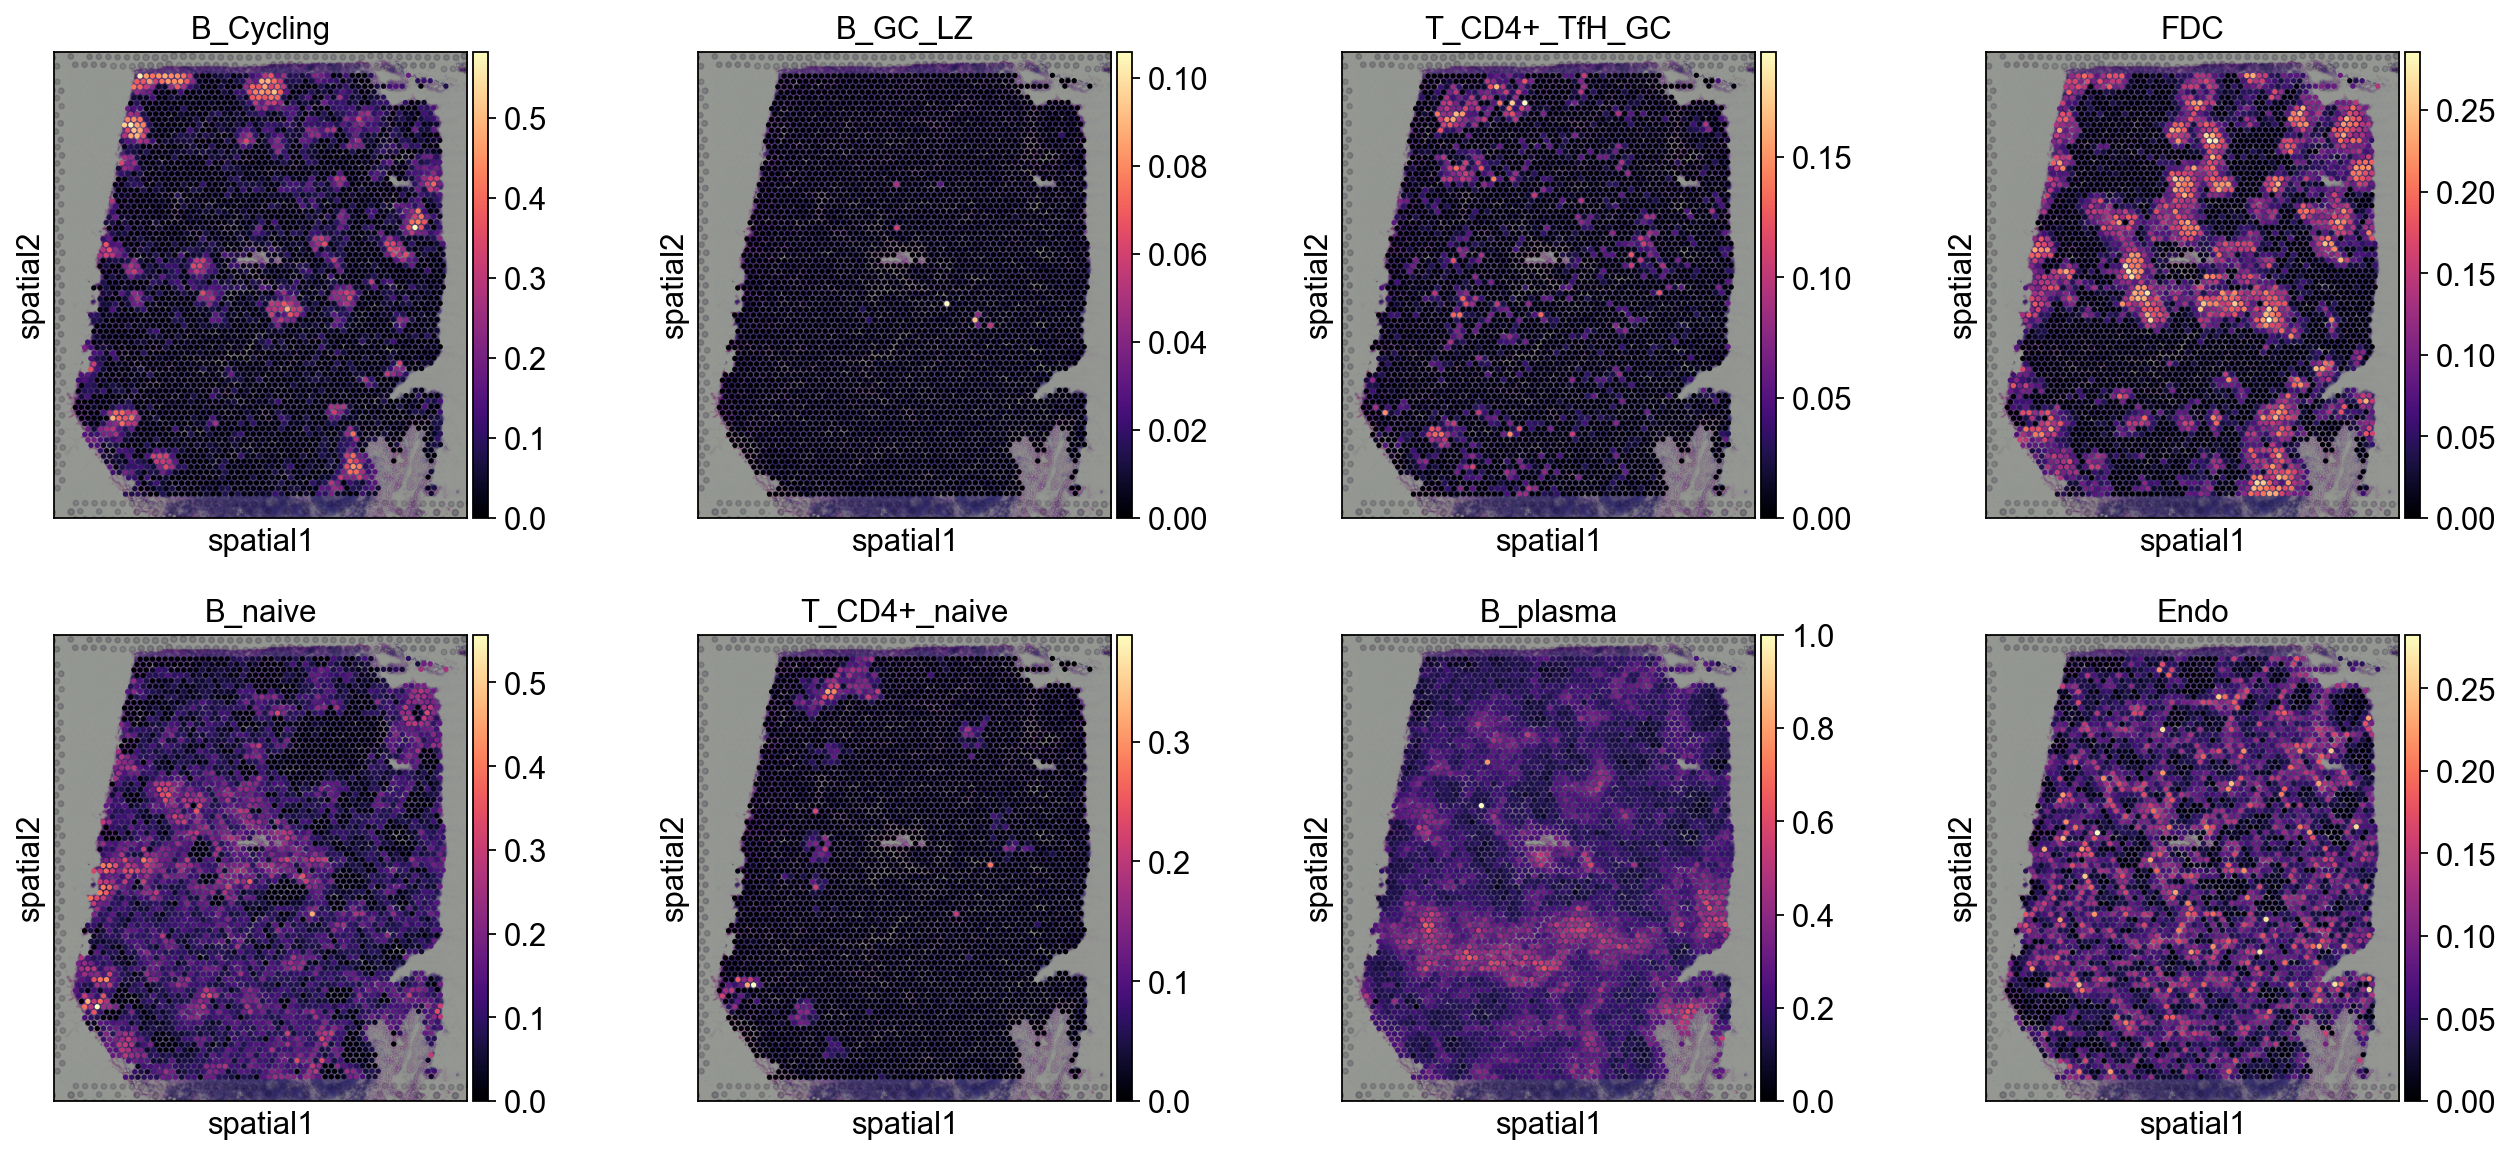

In [9]:
# Select cell types to visualize
annotation_list=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo']

# Plot spatial distribution
sc.pl.spatial(
    decov_obj.adata_cell2location, 
    cmap='magma',
    color=annotation_list,
    ncols=4, 
    size=1.3,
    img_key='hires',
)

### 3.2 Dominant cell type visualization

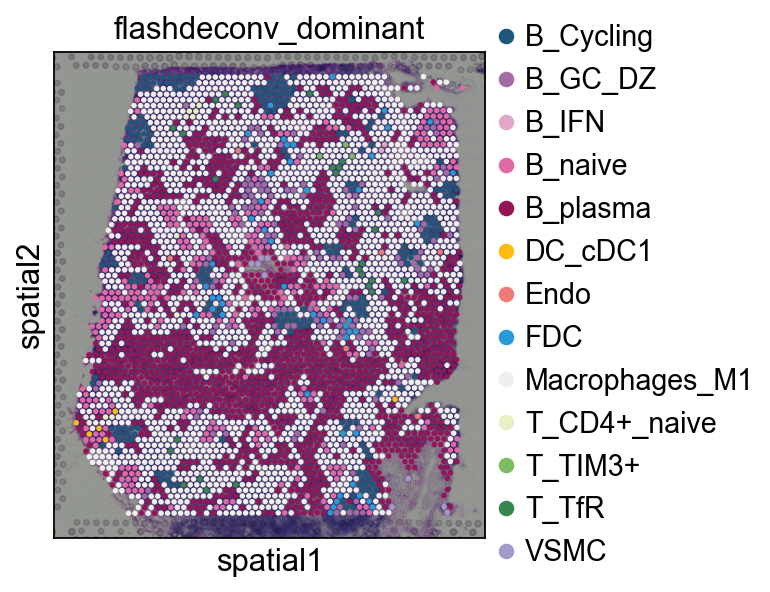

In [10]:
# Plot dominant cell type per spot
sc.pl.spatial(
    decov_obj.adata_sp,
    color='flashdeconv_dominant',
    size=1.3,
    img_key='hires',
)

### 3.3 Multi-target overlay

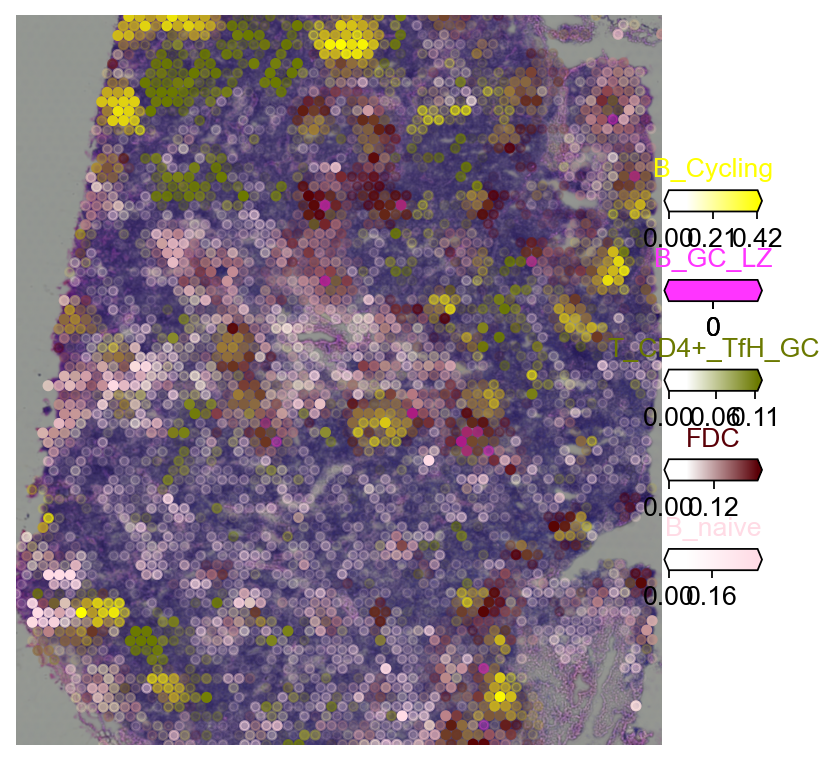

In [11]:
import matplotlib as mpl

# Create color dictionary from reference
if 'Subset_colors' in adata_sc.uns:
    color_dict = dict(zip(
        adata_sc.obs['Subset'].cat.categories,
        adata_sc.uns['Subset_colors']
    ))
else:
    color_dict = None

clust_labels = annotation_list[:5]

with mpl.rc_context({'figure.figsize': (6, 6), 'axes.grid': False}):
    fig = ov.pl.plot_spatial(
        adata=decov_obj.adata_cell2location,
        color=clust_labels, 
        labels=clust_labels,
        show_img=True,
        style='fast',
        max_color_quantile=0.992,
        circle_diameter=4,
        colorbar_position='right',
        palette=color_dict
    )

### 3.4 Pie chart visualization (cropped region)

Adding image layer `image`



00%|██████████| 417/417 [00:01<00:00, 258.86it/s]

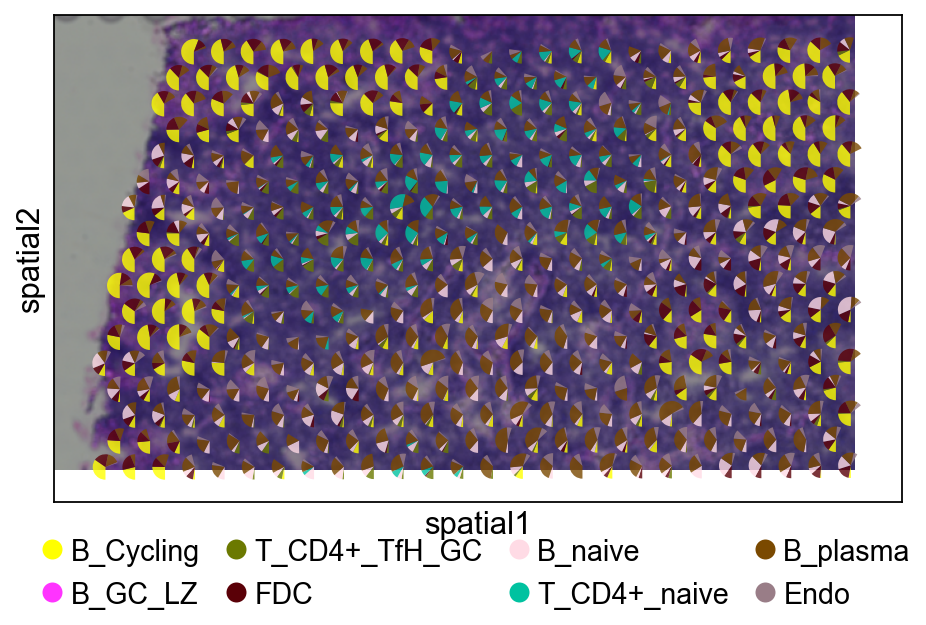

In [12]:
# Crop a region of interest
adata_cropped = ov.space.crop_space_visium(
    decov_obj.adata_cell2location, 
    crop_loc=(0, 0),      
    crop_area=(500, 1000), 
    library_id=list(decov_obj.adata_cell2location.uns['spatial'].keys())[0], 
    scale=1
)

# Plot with pie charts
fig, ax = plt.subplots(figsize=(8, 4))
sc.pl.spatial(
    adata_cropped, 
    basis='spatial',
    color=None,  
    size=1.3,
    img_key='hires',
    ax=ax,      
    show=False
)

ov.pl.add_pie2spatial(
    adata_cropped,
    img_key='hires',
    cell_type_columns=annotation_list,
    ax=ax,
    colors=color_dict,
    pie_radius=10,
    remainder='gap',
    legend_loc=(0.5, -0.25),
    ncols=4,
    alpha=0.8
)
plt.show()

## Comparison: FlashDeconv vs Other Methods

| Feature | FlashDeconv | Tangram | cell2location |
|---------|-------------|---------|---------------|
| GPU Required | No | Optional | Recommended |
| Speed (10k spots) | ~2 min | ~15 min | ~60 min |
| Visium HD Support | Yes (native) | Limited | Limited |
| Spatial Regularization | Built-in | No | No |
| API Style | scanpy-like | Custom | Custom |

## Tips and Troubleshooting

### Parameter Tuning

- **For noisy/sparse data**: Increase `lambda_spatial` (e.g., 10000)
- **For dense data (Visium HD 2μm)**: Increase `sketch_dim` (e.g., 1024)
- **For better accuracy**: Increase `n_hvg` (e.g., 3000)

### Common Issues

1. **Few overlapping genes**: Ensure gene names match between spatial and reference data
2. **Missing spatial coordinates**: Check `adata.obsm['spatial']` exists
3. **Memory issues with large data**: FlashDeconv is memory-efficient, but for very large datasets, consider subsetting

## Citation

If you use FlashDeconv in your research, please cite:

```
Yang, C., Chen, J. & Zhang, X. FlashDeconv enables atlas-scale,
multi-resolution spatial deconvolution via structure-preserving sketching.
bioRxiv (2025). https://doi.org/10.64898/2025.12.22.696108
```

Also cite OmicVerse for the unified API:

```
Zeng, Z., et al. OmicVerse: a framework for bridging and accelerating 
single-cell multiomics analysis with deep learning.
```